In [1]:
import matplotlib.pyplot as plt
import numba
import numpy as np
from ripser import ripser
from scipy.spatial.distance import pdist, squareform
import umap
import torch
import plotly.graph_objects as go
from persim import plot_diagrams
import pandas as pd
from circular_cords import get_coords
from fix_umap_bug import fix_umap_bug
from main import Net
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from cosine_hack import umap_hack

fix_umap_bug()

Import the data. "activity" is then a 60000xneurons matrix with all activations.

In [79]:
layer = "conv2"
activity = np.load(f"activations/MNIST/{layer}.npy")
print(activity.shape)
neurons = activity.shape[1]

(60000, 64)


In [80]:
cluster_info = pd.read_pickle(f"activations/clusters/{layer}.pkl")
print(cluster_info.info())
cluster_info.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 33 to 48
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cluster_id           50 non-null     int32  
 1   cluster_size         50 non-null     int64  
 2   cluster_members      50 non-null     object 
 3   longest_bar          50 non-null     float64
 4   Top 10 longest bars  50 non-null     object 
dtypes: float64(1), int32(1), int64(1), object(2)
memory usage: 2.1+ KB
None


cluster_id  cluster_size  \
33          33           533   
24          24           677   
43          43           350   
9            9          1856   
46          46           361   

                                      cluster_members  longest_bar  \
33  [109, 157, 161, 189, 396, 492, 592, 757, 850, ...     1.740590   
24  [147, 192, 203, 459, 461, 553, 577, 636, 746, ...     1.687230   
43  [324, 332, 581, 650, 652, 742, 822, 1112, 1231...     1.612783   
9   [83, 130, 136, 141, 160, 215, 351, 370, 373, 3...     1.401469   
46  [202, 495, 605, 654, 673, 748, 753, 755, 1230,...     1.340026   

                                  Top 10 longest bars  
33  [0.09480538964271545, 0.10065853595733643, 0.1...  
24  [0.22441330552101135, 0.24619531631469727, 0.2...  
43  [0.08662901818752289, 0.1036023497581482, 0.10...  
9   [0.31129419803619385, 0.3166142702102661, 0.33...  
46  [0.07921493053436279, 0.08427608013153076, 0.1...

In [81]:
cluster_num = 33
cluster = activity[cluster_info["cluster_members"][cluster_num]]
print(cluster.shape)

(533, 64)


In [82]:
layout2 = umap.UMAP(
    n_components=neurons, verbose=False, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster)
# layout2 = cluster
M = squareform(pdist(layout2, "euclidean"))

In [83]:
maxdim = 1
coeff = 47
thresh = np.max(M[~np.isinf(M)])
persistence = ripser(
    M, maxdim=maxdim, coeff=coeff, do_cocycles=True, distance_matrix=True, thresh=thresh
)

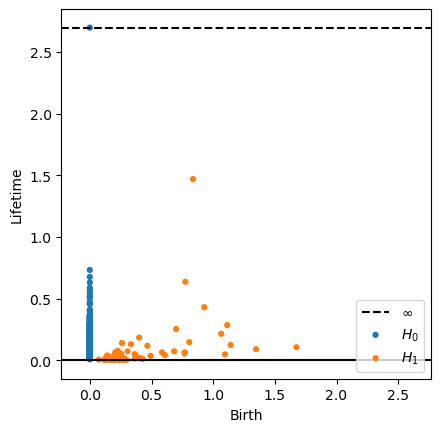

In [84]:
plot_diagrams(persistence["dgms"], lifetime=True, show=True)

In [51]:
f = cluster_info["circle_param"][cluster_num]

KeyError: 'circle_param'

Use the code to compute a circular parameter for the identified circle using circular parametrization (de Silva):

In [86]:
layout_3d = umap.UMAP(
    n_components=3, verbose=False, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster)

In [88]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=layout_3d[:, 0],
            y=layout_3d[:, 1],
            z=layout_3d[:, 2],
            mode="markers",
            marker=dict(
                size=12, color=f, colorscale="hsv", opacity=0.8, showscale=True
            ),
        )
    ]
)
# Cyclic colors: 'twilight', 'twilight_shifted', 'hsv', Default: Viridis
fig.update_layout(
    autosize=False, width=1000, height=700, margin=dict(l=0, r=0, b=0, t=0)
)
# fig.write_html("circular_feature_3D.html")
fig.show()

In [85]:
diagrams = persistence[
    "dgms"
]  # the multiset describing the lives of the persistence classes
cocycles = persistence["cocycles"][
    1
]  # the cocycle representatives for the 1-dim classes
births1 = diagrams[1][:, 0]  # the time of birth for the 1-dim classes
deaths1 = diagrams[1][:, 1]  # the time of death for the 1-dim classes
lives1 = deaths1 - births1  # the lifetime for the 1-dim classes
iMax = np.argsort(lives1)

circle_num = 1

threshold = births1[iMax[-circle_num]] + (
    deaths1[iMax[-circle_num]] - births1[iMax[-circle_num]]
) * (9 / 10)


f, theta_matrix, verts, num_verts = get_coords(
    cocycle=cocycles[iMax[-circle_num]],
    threshold=threshold,
    num_sampled=len(layout2),
    dists=M,
    coeff=coeff,
    bool_smooth_circle="perea",  # "graph", "old", "perea"
)

number of vertices = 533
number of edges = 29684


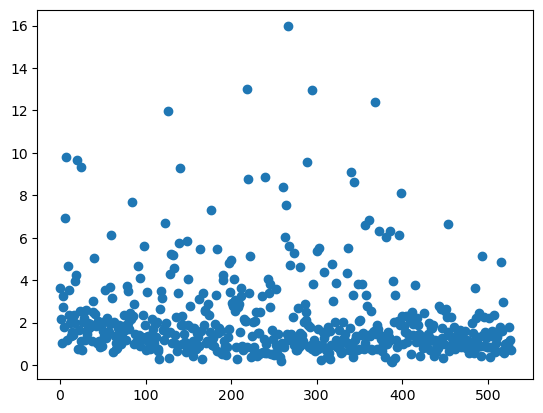

In [11]:
inform_rates = cluster_info["info_per_node"][cluster_num]
plt.scatter(range(neurons), inform_rates)
plt.show()

Not all neurons contribute equally to this circle. We identify the ones that tune to it: 

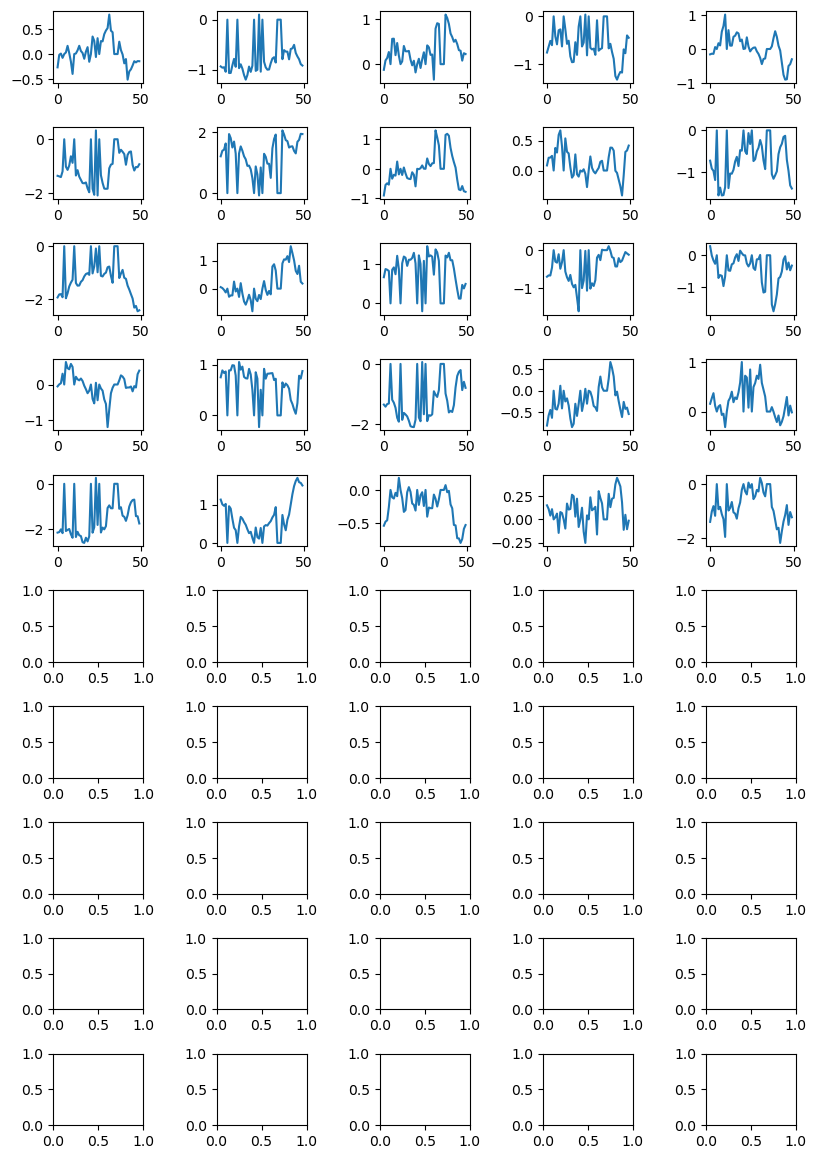

In [46]:
circ_rates = np.zeros([neurons, 50])
counts, bins = np.histogram(f, bins=50, density=True)
for b in range(len(bins) - 1):
    for n in range(neurons):
        rates = []
        for x in range(len(cluster)):
            if bins[b] < f[x] <= bins[b + 1]:
                rates.append(cluster[x, n])
        if rates:
            circ_rates[n, b] = np.mean(rates)
        else:
            circ_rates[n, b] = 0

fig, axs = plt.subplots(10, 5, figsize=(8.27, 11.69))
for n in range(5):
    for m in range(5):
        axs[m, n].plot(range(50), circ_rates[m * 5 + n])
fig.tight_layout()

To quantify this we compute the information rate of the neurons:

[15.61993283283223, -9.247521007846236, 14.047758627070586, -14.399913158475272, -2.8344871061901147, -21.79476012551405, 16.33403630008158, -8.271283655408029, 8.22890746553836, -8.595915202132023, -10.88415708267483, -0.42075309080514733, 13.606346860494753, -18.94294571587531, -25.739037941399882, -25.55164482536387, 10.28398477443193, -18.794103066932465, -11.526612311589147, 14.635221018965986, -26.316159284608798, 9.181714743888081, -5.612619310353317, 6.65814048217242, -35.211726676213324, 10.167535226543539, 18.730449916062785, -10.181367414233874, 13.504509279699336, -12.519745202402115, 4.352617361292271, -14.559521390555632]


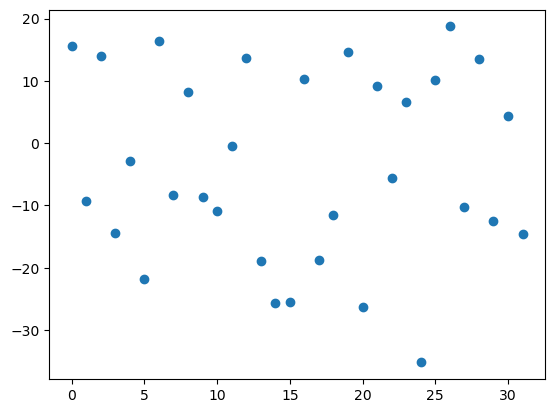

In [47]:
def inform_rate(mean_n, data, coun):
    return np.sum(data * np.log2(np.abs((data / mean_n)) + 0.000001) * coun)


mean = np.mean(cluster, axis=0)

inform_rates = [inform_rate(mean[n], circ_rates[n, :], counts) for n in range(neurons)]
print(inform_rates)

plt.scatter(range(neurons), inform_rates)
plt.show()

Then we pick the ones with an information rate higher then 6:

In [58]:
inform = 10
high_inform = np.where(np.abs(np.array(inform_rates)) > inform)[0]
print(high_inform)
len(high_inform)

[ 0  2  3  5  6 10 12 13 14 15 16 17 18 19 20 24 25 26 27 28 29 31]


22

Lets compute everything again but just with these neurons:

In [59]:
cluster_new = cluster[:, np.where(np.array(inform_rates) > inform)[0]]
data_new = activity[:, np.where(np.array(inform_rates) > inform)[0]]

layout_3d_cluster = umap.UMAP(
    n_components=3, verbose=False, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster_new)

In [64]:
cluster_new = cluster_new[
    np.where(
        (np.array(layout_3d_cluster)[:, 0] > 0)
        & (np.array(layout_3d_cluster)[:, 1] > -5)
        & (np.array(layout_3d_cluster)[:, 2] < 8)
    )[0],
    :,
]
# cluster_new_crop = cluster_new
layout_3d_cluster = umap.UMAP(
    n_components=3, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster_new)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=3, n_neighbors=20, verbose=True)
Wed Jun  1 13:22:27 2022 Construct fuzzy simplicial set
Wed Jun  1 13:22:27 2022 Finding Nearest Neighbors
Wed Jun  1 13:22:27 2022 Finished Nearest Neighbor Search
Wed Jun  1 13:22:27 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Jun  1 13:22:28 2022 Finished embedding


In [65]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=layout_3d_cluster[:, 0],
            y=layout_3d_cluster[:, 1],
            z=layout_3d_cluster[:, 2],
            mode="markers",
            marker=dict(
                size=12,
                color=f,
                colorscale="hsv",
                opacity=0.8,
                showscale=True,
            ),
        )
    ]
)
fig.update_layout(
    autosize=False, width=1000, height=700, margin=dict(l=0, r=0, b=0, t=0)
)
# fig.write_html("circular_feature_3D_after_clustering_copy.html")
fig.show()

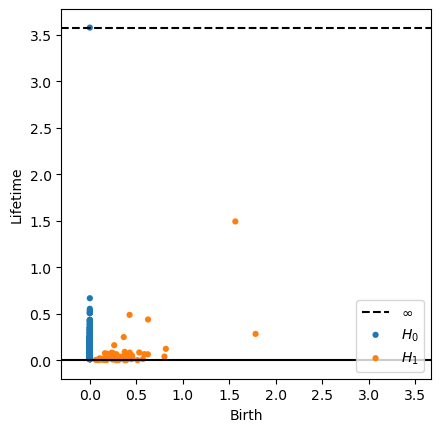

In [66]:
layout3 = umap.UMAP(
    n_components=len(high_inform),
    verbose=False,
    n_neighbors=20,
    min_dist=0.01,
    metric="cosine",
).fit_transform(cluster_new)
M = squareform(pdist(layout3, "euclidean"))
maxdim = 1
coeff = 47
thresh = np.max(M[~np.isinf(M)])
persistence = ripser(
    M, maxdim=maxdim, coeff=coeff, do_cocycles=True, distance_matrix=True, thresh=thresh
)
diagrams = persistence[
    "dgms"
]  # the multiset describing the lives of the persistence classes

plot_diagrams(diagrams, show=True, lifetime=True)
cocycles = persistence["cocycles"][
    1
]  # the cocycle representatives for the 1-dim classes
births1 = diagrams[1][:, 0]  # the time of birth for the 1-dim classes
deaths1 = diagrams[1][:, 1]  # the time of death for the 1-dim classes
lives1 = deaths1 - births1  # the lifetime for the 1-dim classes
iMax = np.argsort(lives1)

threshold = births1[iMax[-1]] + (deaths1[iMax[-1]] - births1[iMax[-1]]) * (9 / 10)

cocycle = cocycles[iMax[-1]]

In [67]:
f_new, theta_matrix, verts_new, num_verts = get_coords(
    cocycle,
    threshold,
    len(layout3),
    M,
    47,
    "perea",  # "graph", "old", "perea"
)

number of vertices = 586
number of edges = 45171


In [68]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=layout_3d_cluster[:, 0],
            y=layout_3d_cluster[:, 1],
            z=layout_3d_cluster[:, 2],
            mode="markers",
            marker=dict(
                size=12,
                color=f_new,
                colorscale="hsv",
                opacity=0.8,
                showscale=True,
            ),
        )
    ]
)
fig.update_layout(
    autosize=False, width=1000, height=700, margin=dict(l=0, r=0, b=0, t=0)
)
# fig.write_html("circular_feature_3D_final_v2_copy.html")
fig.show()

We visulize the circle using using the lucent library. For that end we calculate average activation vectors for 50 overlapping patches along the circular parameter, Then we visulize those 50 average activation vectors. 

In [69]:
f = f_new

In [70]:
buckets = 10
linsp = np.linspace(f.min(), f.max(), buckets + 1)

clusters_overlap = []
for a in range(1, buckets):
    c = []
    for p in range(len(f)):
        if linsp[a - 1] < f[p] < linsp[a + 1]:
            c.append(cluster[p])
    clusters_overlap.append(c)

c = []
for p in range(len(f)):
    if linsp[buckets - 1] < f[p] or f[p] < linsp[1]:
        c.append(cluster[p])
clusters_overlap.append(c)
av_clusters_overlap = [np.mean(overlap, axis=0) for overlap in clusters_overlap]

print(list(map(lambda a: a.shape, av_clusters_overlap)))
print(list(map(len, clusters_overlap)))

[(32,), (32,), (32,), (32,), (32,), (32,), (32,), (32,), (32,), (32,)]
[199, 211, 42, 81, 62, 24, 79, 116, 202, 154]


In [78]:
from lucent.optvis import render, param, transform, objectives
from lucent.misc.io.showing import animate_sequence
from lucent.modelzoo.util import get_model_layers

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net()
model.load_state_dict(torch.load("mnist_cnn.pt"))
model.to(device).eval()
param_f = lambda: param.image(28, batch=0, channels=1)
print(get_model_layers(model))

pics = []
channel = lambda n: objectives.channel(layer, n)
for n in range(len(av_clusters_overlap)):
    a = []
    for m in range(len(high_inform)):
        a.append(av_clusters_overlap[n][m] * channel(high_inform[m]))
    obj = sum(a)
    d = render.render_vis(model, obj, param_f, show_inline=True)
    pics.append(d)

['conv1', 'conv2', 'dropout1', 'dropout2', 'fc1', 'fc2']


  0%|                                                     | 0/512 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/act/lib/python3.9/site-packages/lucent/optvis/render.py:103: UserWarning:

Some layers could not be computed because the size of the image is not big enough. It is fine, as long as the noncomputed layers are not used in the objective function(exception details: 'output with shape [1, 53, 53] doesn't match the broadcast shape [3, 53, 53]')

  0%|                                                     | 0/512 [00:00<?, ?it/s]


AssertionError: There are no saved feature maps. Make sure to put the model in eval mode, like so: `model.to(device).eval()`. See README for example.

In [74]:
def interpolate_param_f():
    # We start with a batch of FFT parameterized images
    params, image_f = param.fft_image((2, 1, 28, 28))
    # We then add a bunch of low-res interpolated tensors
    shared = [
        param.lowres_tensor((2, 1, 28, 28), (1, 1, 28 // 2, 28 // 2)),
        param.lowres_tensor((2, 1, 28, 28), (1, 1, 28 // 4, 28 // 4)),
        # param.lowres_tensor((6, 1, 28, 28), (1, 1, 28//8, 28//8)),
        # param.lowres_tensor((6, 1, 28, 28), (2, 1, 28//8, 28//8)),
        # param.lowres_tensor((6, 1, 28, 28), (1, 1, 28//16, 28//16)),
        # param.lowres_tensor((6, 1, 28, 28), (2, 1, 28//16, 28//16)),
    ]
    # Accumulate the params and outputs
    images = []
    for (p, i) in shared:
        params += p
        images.append(i)
    return params, param.to_valid_rgb(
        lambda: image_f() + sum([i() for i in images]), decorrelate=True
    )


# This objective function adjusts relative proportions of the two objectives
# gradually from the first image to the last
obj = objectives.channel_interpolate("conv1", 1, "conv1", 2)

sequence = render.render_vis(model, obj, interpolate_param_f, show_inline=True)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1568x1 and 3x3)

In [57]:
buckets = 10
linsp = np.linspace(f_2.min(), f_2.max(), buckets + 1)

clusters_overlap = []
for a in range(1, buckets):
    c = []
    for p in range(len(f_2)):
        if linsp[a - 1] < f_2[p] < linsp[a + 1]:
            c.append(cluster_new[p])
    clusters_overlap.append(c)

c = []
for p in range(len(f_new)):
    if linsp[buckets - 1] < f_2[p] or f_2[p] < linsp[1]:
        c.append(cluster_new[p])
clusters_overlap.append(c)
av_clusters_overlap = [np.mean(overlap, axis=0) for overlap in clusters_overlap]

print(list(map(lambda a: a.shape, av_clusters_overlap)))
print(list(map(len, clusters_overlap)))

[(30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,)]
[375, 371, 287, 234, 139, 344, 302, 133, 108, 131]


Using cache found in /Users/sturla/.cache/torch/hub/pytorch_vision_v0.10.0
100%|█████████████████████████████████████████████████████| 512/512 [01:06<00:00,  7.70it/s]



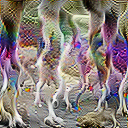

100%|█████████████████████████████████████████████████████| 512/512 [01:02<00:00,  8.22it/s]



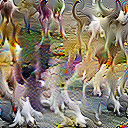

100%|█████████████████████████████████████████████████████| 512/512 [00:59<00:00,  8.63it/s]



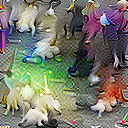

100%|█████████████████████████████████████████████████████| 512/512 [01:04<00:00,  7.97it/s]



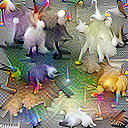

100%|█████████████████████████████████████████████████████| 512/512 [01:04<00:00,  7.96it/s]



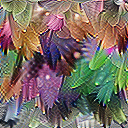

100%|█████████████████████████████████████████████████████| 512/512 [01:08<00:00,  7.48it/s]



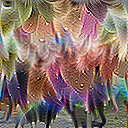

100%|█████████████████████████████████████████████████████| 512/512 [01:06<00:00,  7.64it/s]



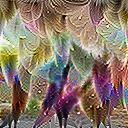

100%|█████████████████████████████████████████████████████| 512/512 [01:22<00:00,  6.20it/s]



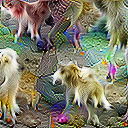

100%|█████████████████████████████████████████████████████| 512/512 [01:16<00:00,  6.72it/s]



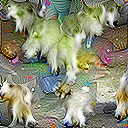

100%|█████████████████████████████████████████████████████| 512/512 [01:08<00:00,  7.44it/s]



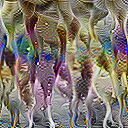

In [58]:
from lucent.optvis import render, param, transform, objectives

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.hub.load("pytorch/vision:v0.10.0", "googlenet", pretrained=True).eval()

pics_2 = []
channel = lambda n: objectives.channel(layer, n)
for n in range(len(av_clusters_overlap)):
    a = []
    for m in range(len(high_inform)):
        a.append(av_clusters_overlap[n][m] * channel(high_inform[m]))
    obj = sum(a)
    d = render.render_vis(model, obj, show_inline=True)
    pics_2.append(d)

In [23]:
buckets = 10
linsp = np.linspace(f_3.min(), f_3.max(), buckets + 1)

clusters_overlap = []
for a in range(1, buckets):
    c = []
    for p in range(len(f_3)):
        if linsp[a - 1] < f_3[p] < linsp[a + 1]:
            c.append(cluster_new[p])
    clusters_overlap.append(c)

c = []
for p in range(len(f_3)):
    if linsp[buckets - 1] < f_3[p] or f_3[p] < linsp[1]:
        c.append(cluster_new[p])
clusters_overlap.append(c)
av_clusters_overlap = [np.mean(overlap, axis=0) for overlap in clusters_overlap]

print(list(map(lambda a: a.shape, av_clusters_overlap)))
print(list(map(len, clusters_overlap)))

[(30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,)]
[678, 721, 414, 56, 15, 20, 30, 81, 74, 335]


Using cache found in /Users/sturla/.cache/torch/hub/pytorch_vision_v0.10.0
100%|███████████████████████████████████| 512/512 [01:05<00:00,  7.87it/s]



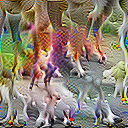

100%|███████████████████████████████████| 512/512 [01:06<00:00,  7.68it/s]



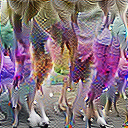

100%|███████████████████████████████████| 512/512 [01:06<00:00,  7.67it/s]



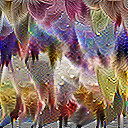

100%|███████████████████████████████████| 512/512 [01:12<00:00,  7.06it/s]



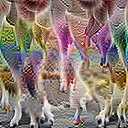

100%|███████████████████████████████████| 512/512 [01:13<00:00,  7.01it/s]



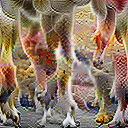

100%|███████████████████████████████████| 512/512 [01:06<00:00,  7.68it/s]



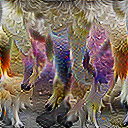

100%|███████████████████████████████████| 512/512 [01:12<00:00,  7.09it/s]



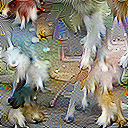

100%|███████████████████████████████████| 512/512 [01:19<00:00,  6.44it/s]



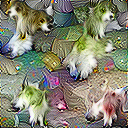

100%|███████████████████████████████████| 512/512 [01:08<00:00,  7.43it/s]



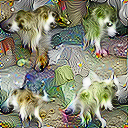

100%|███████████████████████████████████| 512/512 [01:02<00:00,  8.16it/s]



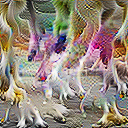

In [24]:
from lucent.optvis import render, param, transform, objectives

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.hub.load("pytorch/vision:v0.10.0", "googlenet", pretrained=True).eval()

pics_3 = []
channel = lambda n: objectives.channel(layer, n)
for n in range(len(av_clusters_overlap)):
    a = []
    for m in range(len(high_inform)):
        a.append(av_clusters_overlap[n][m] * channel(high_inform[m]))
    obj = sum(a)
    d = render.render_vis(model, obj, show_inline=True)
    pics_3.append(d)

In [59]:
buckets = 50
linsp = np.linspace(f_new.min(), f_new.max(), buckets + 1)

clusters_overlap = []
for a in range(1, buckets):
    c = []
    for p in range(len(f_new)):
        if linsp[a - 1] < f_new[p] < linsp[a + 1]:
            c.append(cluster_new[p])
    clusters_overlap.append(c)

c = []
for p in range(len(f_new)):
    if linsp[buckets - 1] < f_new[p] or f_new[p] < linsp[1]:
        c.append(cluster_new[p])
clusters_overlap.append(c)
av_clusters_overlap = [np.mean(overlap, axis=0) for overlap in clusters_overlap]

print(list(map(lambda a: a.shape, av_clusters_overlap)))
print(list(map(len, clusters_overlap)))

[(30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,)]
[2, 4, 12, 14, 6, 2, 3, 4, 8, 16, 30, 90, 83, 32, 52, 221, 210, 108, 131, 93, 78, 49, 86, 130, 103, 56, 35, 24, 9, 10, 13, 11, 27, 49, 40, 20, 9, 21, 216, 224, 34, 14, 9, 6, 8, 7, 3, 3, 4, 5]


Using cache found in /Users/sturla/.cache/torch/hub/pytorch_vision_v0.10.0
100%|█████████████████████████████████████████████████████| 512/512 [01:23<00:00,  6.11it/s]



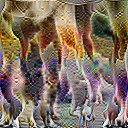

100%|█████████████████████████████████████████████████████| 512/512 [01:37<00:00,  5.25it/s]



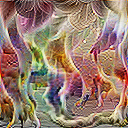

100%|█████████████████████████████████████████████████████| 512/512 [01:40<00:00,  5.10it/s]



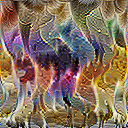

100%|█████████████████████████████████████████████████████| 512/512 [01:40<00:00,  5.09it/s]



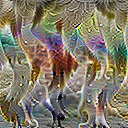

100%|█████████████████████████████████████████████████████| 512/512 [01:34<00:00,  5.39it/s]



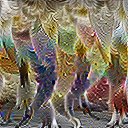

100%|█████████████████████████████████████████████████████| 512/512 [01:13<00:00,  7.01it/s]



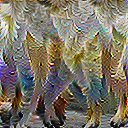

100%|█████████████████████████████████████████████████████| 512/512 [01:12<00:00,  7.07it/s]



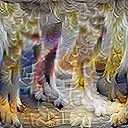

100%|█████████████████████████████████████████████████████| 512/512 [01:17<00:00,  6.56it/s]



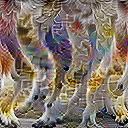

100%|█████████████████████████████████████████████████████| 512/512 [01:13<00:00,  6.99it/s]



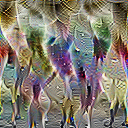

100%|█████████████████████████████████████████████████████| 512/512 [01:13<00:00,  6.98it/s]



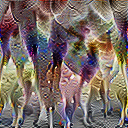

100%|█████████████████████████████████████████████████████| 512/512 [01:13<00:00,  6.98it/s]



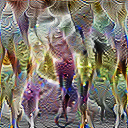

100%|█████████████████████████████████████████████████████| 512/512 [01:14<00:00,  6.90it/s]



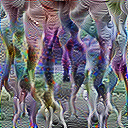

100%|█████████████████████████████████████████████████████| 512/512 [01:14<00:00,  6.89it/s]



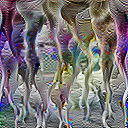

100%|█████████████████████████████████████████████████████| 512/512 [01:26<00:00,  5.90it/s]



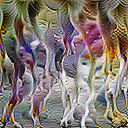

100%|█████████████████████████████████████████████████████| 512/512 [01:13<00:00,  6.93it/s]



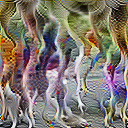

100%|█████████████████████████████████████████████████████| 512/512 [01:19<00:00,  6.47it/s]



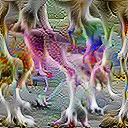

100%|█████████████████████████████████████████████████████| 512/512 [01:13<00:00,  7.01it/s]



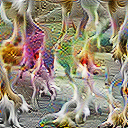

100%|█████████████████████████████████████████████████████| 512/512 [01:13<00:00,  6.98it/s]



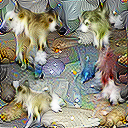

100%|█████████████████████████████████████████████████████| 512/512 [01:13<00:00,  7.01it/s]



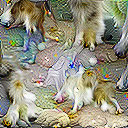

100%|█████████████████████████████████████████████████████| 512/512 [01:16<00:00,  6.72it/s]



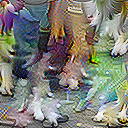

100%|█████████████████████████████████████████████████████| 512/512 [01:18<00:00,  6.52it/s]



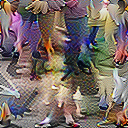

100%|█████████████████████████████████████████████████████| 512/512 [01:18<00:00,  6.49it/s]



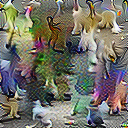

100%|█████████████████████████████████████████████████████| 512/512 [01:17<00:00,  6.61it/s]



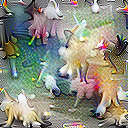

100%|█████████████████████████████████████████████████████| 512/512 [01:21<00:00,  6.31it/s]



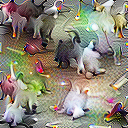

100%|█████████████████████████████████████████████████████| 512/512 [01:17<00:00,  6.59it/s]



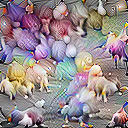

100%|█████████████████████████████████████████████████████| 512/512 [01:16<00:00,  6.68it/s]



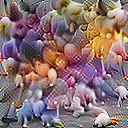

100%|█████████████████████████████████████████████████████| 512/512 [01:18<00:00,  6.49it/s]



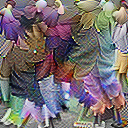

100%|█████████████████████████████████████████████████████| 512/512 [01:23<00:00,  6.16it/s]



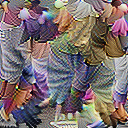

100%|█████████████████████████████████████████████████████| 512/512 [01:12<00:00,  7.11it/s]



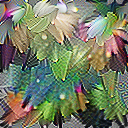

100%|█████████████████████████████████████████████████████| 512/512 [01:12<00:00,  7.03it/s]



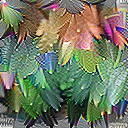

100%|█████████████████████████████████████████████████████| 512/512 [01:11<00:00,  7.18it/s]



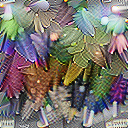

100%|█████████████████████████████████████████████████████| 512/512 [01:12<00:00,  7.10it/s]



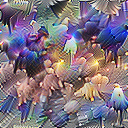

100%|█████████████████████████████████████████████████████| 512/512 [01:11<00:00,  7.17it/s]



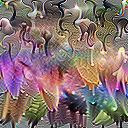

100%|█████████████████████████████████████████████████████| 512/512 [01:11<00:00,  7.18it/s]



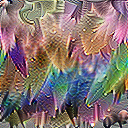

100%|█████████████████████████████████████████████████████| 512/512 [01:12<00:00,  7.05it/s]



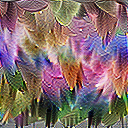

100%|█████████████████████████████████████████████████████| 512/512 [01:11<00:00,  7.13it/s]



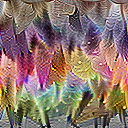

100%|█████████████████████████████████████████████████████| 512/512 [01:11<00:00,  7.17it/s]



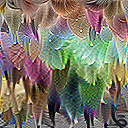

100%|█████████████████████████████████████████████████████| 512/512 [01:12<00:00,  7.03it/s]



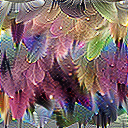

100%|█████████████████████████████████████████████████████| 512/512 [01:14<00:00,  6.83it/s]



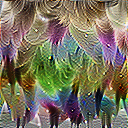

100%|█████████████████████████████████████████████████████| 512/512 [01:14<00:00,  6.90it/s]



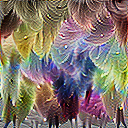

100%|█████████████████████████████████████████████████████| 512/512 [01:13<00:00,  7.00it/s]



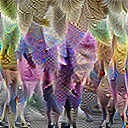

100%|█████████████████████████████████████████████████████| 512/512 [01:12<00:00,  7.09it/s]



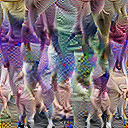

100%|█████████████████████████████████████████████████████| 512/512 [01:12<00:00,  7.07it/s]



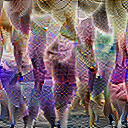

100%|█████████████████████████████████████████████████████| 512/512 [01:12<00:00,  7.08it/s]



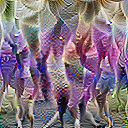

100%|█████████████████████████████████████████████████████| 512/512 [01:22<00:00,  6.17it/s]



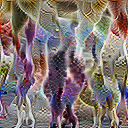

100%|█████████████████████████████████████████████████████| 512/512 [01:36<00:00,  5.33it/s]



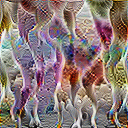

100%|█████████████████████████████████████████████████████| 512/512 [01:17<00:00,  6.59it/s]



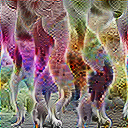

100%|█████████████████████████████████████████████████████| 512/512 [01:19<00:00,  6.47it/s]



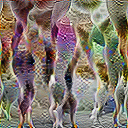

100%|█████████████████████████████████████████████████████| 512/512 [01:16<00:00,  6.67it/s]



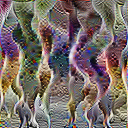

100%|█████████████████████████████████████████████████████| 512/512 [01:15<00:00,  6.81it/s]



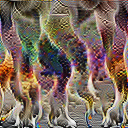

In [60]:
from lucent.optvis import render, param, transform, objectives

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.hub.load("pytorch/vision:v0.10.0", "googlenet", pretrained=True).eval()

pics_f = []
channel = lambda n: objectives.channel(layer, n)
for n in range(len(av_clusters_overlap)):
    a = []
    for m in range(len(high_inform)):
        a.append(av_clusters_overlap[n][m] * channel(high_inform[m]))
    obj = sum(a)
    d = render.render_vis(model, obj, show_inline=True)
    pics_f.append(d)

In [17]:
buckets = 25
linsp = np.linspace(f_2.min(), f_2.max(), buckets + 1)

clusters_overlap = []
for a in range(1, buckets):
    c = []
    for p in range(len(f_2)):
        if linsp[a - 1] < f_2[p] < linsp[a + 1]:
            c.append(cluster_new[p])
    clusters_overlap.append(c)

c = []
for p in range(len(f_2)):
    if linsp[buckets - 1] < f_2[p] or f_2[p] < linsp[1]:
        c.append(cluster_new[p])
clusters_overlap.append(c)
av_clusters_overlap = [np.mean(overlap, axis=0) for overlap in clusters_overlap]

print(list(map(lambda a: a.shape, av_clusters_overlap)))
print(list(map(len, clusters_overlap)))

[(30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,)]
[10, 12, 7, 4, 4, 14, 86, 269, 560, 415, 186, 415, 312, 51, 32, 15, 4, 5, 4, 3, 2, 4, 4, 1, 5]


In [ ]:
from lucent.optvis import render, param, transform, objectives

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.hub.load("pytorch/vision:v0.10.0", "googlenet", pretrained=True).eval()

pics_f_2 = []
channel = lambda n: objectives.channel(layer, n)
for n in range(len(av_clusters_overlap)):
    a = []
    for m in range(len(high_inform)):
        a.append(av_clusters_overlap[n][m] * channel(high_inform[m]))
    obj = sum(a)
    d = render.render_vis(model, obj, show_inline=True)
    pics_f_2.append(d)

In [45]:
for i, im in enumerate(pics):
    np.save(f"data/circle_pics/circle_3/im_{i}.npy", im[0][0])

In [46]:
from PIL import Image

a = np.load("data/circle_pics/circle_3/im_1.npy")

a = (a * 255).astype(np.uint8)

ima = Image.fromarray(obj=a, mode="RGB")
ima.show()

In [51]:
print(cluster[0].shape)

(528,)


In [42]:
def send_forward(activation, x_cor=0, y_cor=0):
    sub_sample = torch.from_numpy(activation)
    up_sample = torch.cat([sub_sample[None, :]] * 256, 0)

    # up_sample = torch.cat([up_sample[:,None]]*14, 1)
    # print(up_sample.shape)
    # up_sample = up_sample.transpose(0, 2).transpose(1, 3)

    upsampled_forward = model.inception4e.forward(up_sample[:, :, None, None])
    return upsampled_forward[:, :, x_cor, y_cor][0].detach().numpy()


next_activation = list(
    map(send_forward, cluster)
)  # [send_forward(activation) for activation in cluster]
print(next_activation)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [43]:
layout_3d = umap.UMAP(
    n_components=3, verbose=False, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(next_activation)

In [54]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=layout_3d[:, 0],
            y=layout_3d[:, 1],
            z=layout_3d[:, 2],
            mode="markers",
            marker=dict(
                size=12, color=f_3, colorscale="hsv", opacity=0.8, showscale=True
            ),
        )
    ]
)
# Cyclic colors: 'twilight', 'twilight_shifted', 'hsv', Default: Viridis
fig.update_layout(
    autosize=False, width=1000, height=700, margin=dict(l=0, r=0, b=0, t=0)
)
fig.write_html("next_layer.html")
fig.show()

In [45]:
print(next_activation[0].shape)

(832,)


In [46]:
layout2 = umap.UMAP(
    n_components=832, verbose=False, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(next_activation)
M = squareform(pdist(layout2, "euclidean"))

In [47]:
thresh = np.max(M[~np.isinf(M)])
persistence = ripser(
    M, maxdim=maxdim, coeff=coeff, do_cocycles=True, distance_matrix=True, thresh=thresh
)

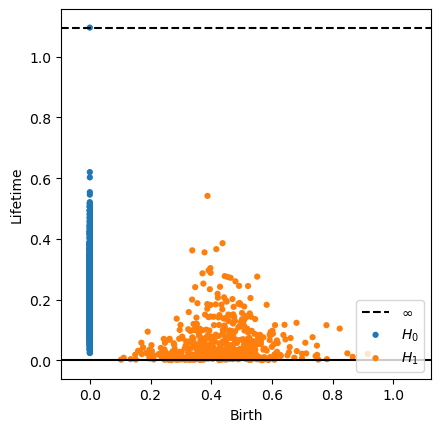

In [48]:
plot_diagrams(persistence["dgms"], lifetime=True, show=True)

In [49]:
diagrams = persistence[
    "dgms"
]  # the multiset describing the lives of the persistence classes
cocycles = persistence["cocycles"][
    1
]  # the cocycle representatives for the 1-dim classes
births1 = diagrams[1][:, 0]  # the time of birth for the 1-dim classes
deaths1 = diagrams[1][:, 1]  # the time of death for the 1-dim classes
lives1 = deaths1 - births1  # the lifetime for the 1-dim classes
iMax = np.argsort(lives1)

circle_num = 1

threshold = births1[iMax[-circle_num]] + (
    deaths1[iMax[-circle_num]] - births1[iMax[-circle_num]]
) * (9 / 10)


f_next, theta_matrix, verts, num_verts = get_coords(
    cocycle=cocycles[iMax[-circle_num]],
    threshold=threshold,
    num_sampled=len(layout2),
    dists=M,
    coeff=coeff,
    bool_smooth_circle="perea",  # "graph", "old", "perea"
)

number of vertices = 1213
number of edges = 43985


In [50]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=layout_3d[:, 0],
            y=layout_3d[:, 1],
            z=layout_3d[:, 2],
            mode="markers",
            marker=dict(
                size=12, color=f_next, colorscale="hsv", opacity=0.8, showscale=True
            ),
        )
    ]
)
# Cyclic colors: 'twilight', 'twilight_shifted', 'hsv', Default: Viridis
fig.update_layout(
    autosize=False, width=1000, height=700, margin=dict(l=0, r=0, b=0, t=0)
)
fig.write_html("next_layer_new_cords.html")
fig.show()